# Homework 1 - Solutions

## Markets Foundations

### UChicago Financial Mathematics

#### September 2023

* Mark Hendricks
* hendricks@uchicago.edu

#### This assignment is not submitted, graded, or for credit. 
Rather, it is assigned for learning purposes.

# Data

This assignment uses the data file `../data/treasury_quotes_2023-06-30.xlsx`.

# 1. Treasury Debt Composition

## Note

The `ITYPE` column identifies
* 1: bonds
* 2: notes
* 4: bills
* 11: TIPS notes
* 12: TIPS bonds

The column `TDPUBOUT` lists the dollar size of the issue (public debt outstanding.)

The data source does not list the issue size for the T-bills, which is why we are not segmenting those out separately.

*Tip* `.pivot_table()` may be useful.

## 1.1
Plot the total amount of outstanding debt maturing at each date

## 1.2
Plot the amount of outstanding debt maturing at each date, segmented by bonds, notes, TIPS (combined ITYPE of 11 and 12.)

## 1.3
Report the total outstanding debt (summed over all maturity dates,) segmented by bonds, notes, TIPS.

## 1.4
Make a pie chart of this total number (reported in 1.3.) 

# <span style="color:red">Solution 1</span>

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *

In [2]:
QUOTE_DATE = '2023-06-30'

filepath_rawdata = f'../data/treasury_quotes_{QUOTE_DATE}.xlsx'
rawdata = pd.read_excel(filepath_rawdata,sheet_name='quotes')
rawdata.columns = rawdata.columns.str.upper()
rawdata.sort_values('TMATDT',inplace=True)
rawdata.set_index('KYTREASNO',inplace=True)

In [3]:
t_check = rawdata['CALDT'].values[0]
if rawdata['CALDT'].eq(t_check).all():
    t_current = t_check
else:
    warnings.warn('Quotes are from multiple dates.')
    t_current = None

In addition to `TDPUBOUT` for total public debt outstanding, 

also try `TDTOTOUT` for total debt outstanding, which also reports bills.

The variable `KEY` below selects which variable is examined.

In [4]:
KEY = 'TDTOTOUT'

## 1.1

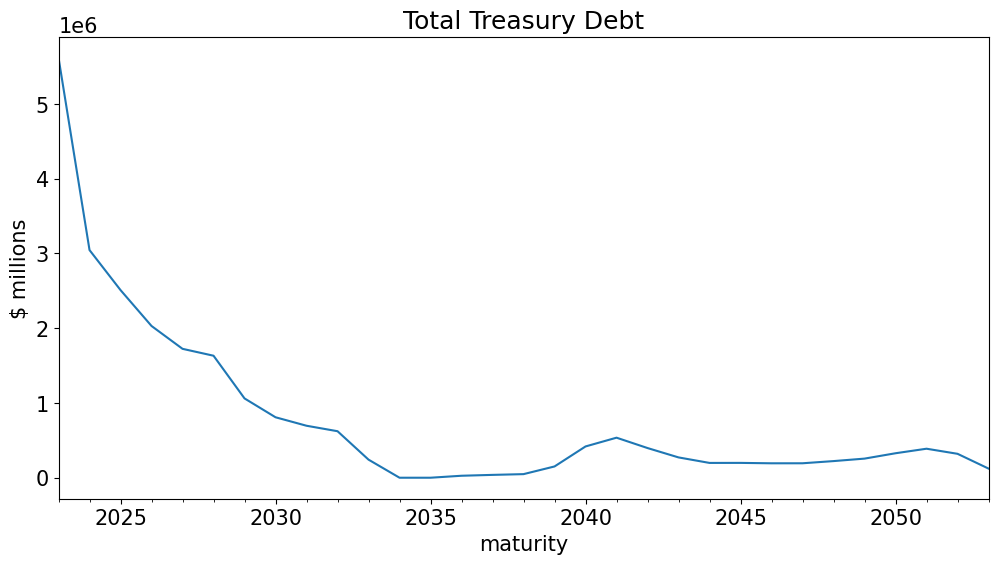

In [5]:
debts = rawdata.pivot_table(values=KEY,index='TMATDT',columns='ITYPE',aggfunc='sum') \
    .resample('Y').sum().rename(columns={1:'bonds',2:'notes',4:'bills'})
debts['TIPS'] = debts[11] + debts[12]
debts.drop(columns=[11,12],inplace=True)

debts.sum(axis=1).plot(title='Total Treasury Debt',ylabel='$ millions',xlabel='maturity');

## 1.2

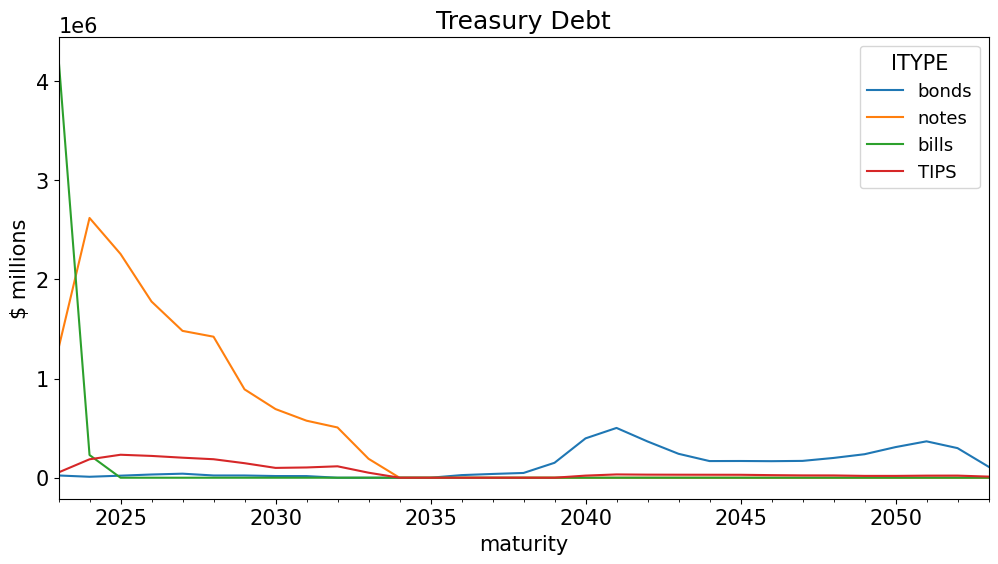

In [6]:
debts.plot(title='Treasury Debt',ylabel='$ millions',xlabel='maturity');

## 1.3

In [7]:
debts.sum().to_frame().rename(columns={0:'debt outstanding ($ millions)'}).style.format('{:,.2f}')

,debt outstanding ($ millions)
ITYPE,
bonds,"4,170,475.00"
notes,"13,723,941.00"
bills,"4,466,694.00"
TIPS,"1,933,627.00"


## 1.4

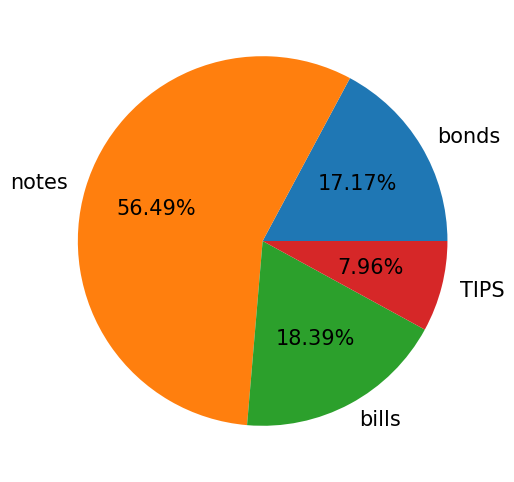

In [8]:
plt.pie(debts.sum().values, labels=debts.columns, autopct='%1.2f%%')
plt.show()

### Not requested, but perhaps interesting to see outstanding via issue

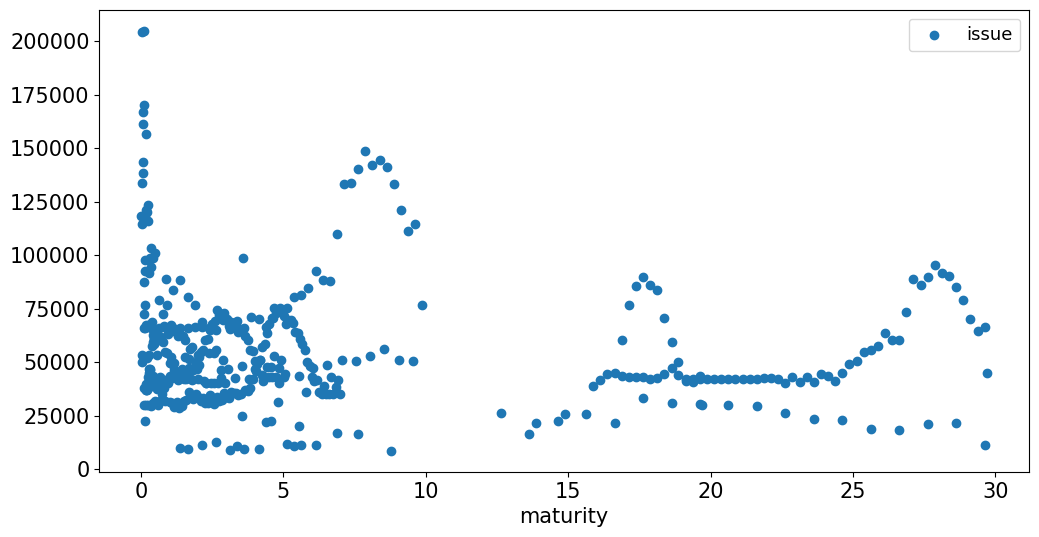

In [9]:
mats = get_maturity_delta(rawdata[['TMATDT']].astype('datetime64[ns]'), t_current=t_current).rename(columns={'TMATDT':'maturity'})

plt.scatter(mats,rawdata[KEY]);
plt.legend(['issue']);
plt.xlabel('maturity');

***

# 2 Bond Metrics

## 2.1

Calculate the time-to-maturity (relative to the quoted date of `2023-05-31`) for each issue.

Use the `TMATDT` column to get the maturity date.

Report the summary statistics of these time-to-maturities. (Consider using .describe()).

## 2.2
Plot the time-to-maturity against the provided YTM, (column `TDYLD`.)

## 2.3

For the Treasury bills, calculate the **discount yields**.

Identify the T-bills using `ITYPE`=4 or looking for `TCOUPRT` of 0.

## 2.4

Write a function to calculate the yield-to-maturity for a semiannual coupon bond with the following stylized parameters: 
* time-to-maturity of 30 years
* coupon rate: 3%
* price: \$87

You will need to use a nonlinear solver to solve for the YTM.

#### Hint 
Consider using `fsolve` to solve the yield implicitly from the nonlinear equation. To that point, try

`from scipy.optimize import fsolve`


## 2.5 Extra

Calculate the YTM of each bond issue in the data. Note that you will get a better YTM estimate if you use a price that is...
* the mean of the **bid** (`TDBID`) and **ask** (`TDASK`)
* includes the **accrued interest** (`TDACCINT`)

Report how far your YTM calculation is from those reported in the data set.

Report your calculated YTM for the issues where the dataset does not compute a YTM.

# <span style="color:red">Solution 2</span>

## <span style="color:red">2.1</span>

In [10]:
mats_issues = get_maturity_delta(rawdata['TMATDT'],t_current=t_current)
mats_issues.describe().to_frame().T.style.format('{:.2f}')

,count,mean,std,min,25%,50%,75%,max
TMATDT,435.00,6.70,8.21,0.01,1.09,3.17,7.08,29.71


## <span style="color:red">2.2</span>

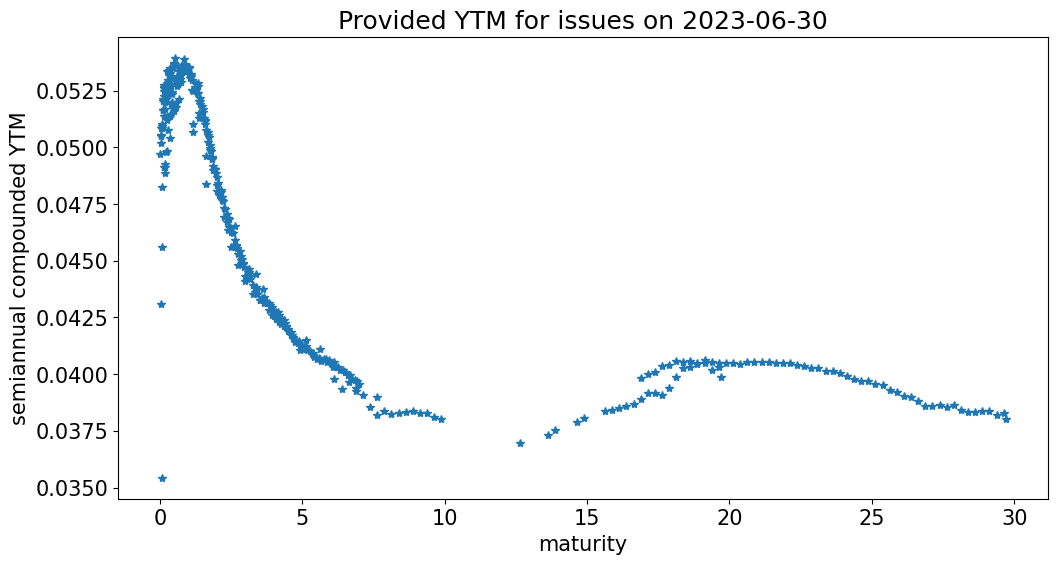

In [11]:
FREQ = 365

plt.plot(mats_issues,rawdata['TDYLD']* FREQ,linestyle='',marker='*')
plt.title(f'Provided YTM for issues on {pd.to_datetime(t_current):%Y-%m-%d}')
plt.ylabel('semiannual compounded YTM')
plt.xlabel('maturity')
plt.show()

## <span style="color:red">2.3</span>

In [12]:
DAYCT_ADJ = 360/365

tbills = rawdata[rawdata['ITYPE']==4]
px_tbills = tbills[['TDASK','TDBID']].mean(axis=1)
mat_bills = get_maturity_delta(tbills['TMATDT'],t_current=t_current)
disc_yield = ((100-px_tbills)/100 / (mat_bills * DAYCT_ADJ)).to_frame().rename(columns={0:'discount yield'})
disc_yield.style.format('{:.2%}')

,discount yield
KYTREASNO,
208008,5.04%
207985,5.09%
208022,5.12%
207913,5.12%
208023,5.15%
207996,5.16%
208024,5.15%
207997,5.17%
208025,5.23%


In [13]:
disc_yield.describe().T.style.format('{:.2%}')

,count,mean,std,min,25%,50%,75%,max
discount yield,5100.00%,5.28%,0.08%,5.04%,5.24%,5.30%,5.33%,5.40%


## <span style="color:red">2.4</span>

In [14]:
from scipy.optimize import fsolve

def pv(rate, cashflows, maturities,freq=1):
    price = sum([cfi/(1+rate/freq)**(maturities[i]*freq) for i, cfi in enumerate(cashflows)])
    return price

In [15]:
RESTRICT_YLD = False
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = False
RESTRICT_REDUNDANT = False

data = filter_treasuries(rawdata, t_date=t_current, filter_yld = RESTRICT_YLD, filter_tips = RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)
CF = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=RESTRICT_DTS_MATURING)

In [16]:
px = (rawdata[['TDASK','TDBID']].mean(axis=1) + rawdata['TDACCINT']).loc[CF.index]
maturity_grid = pd.Series(get_maturity_delta(CF.columns.values,t_current=t_current),index=CF.columns)

ytm = pd.Series(index=px.index,dtype=float)
for idbond in px.index:
    pv_wrapper = lambda y: px.loc[idbond] - pv(y,CF.loc[idbond,:].values,maturity_grid.values,freq=2)
    ytm.loc[idbond] = fsolve(pv_wrapper,.01)

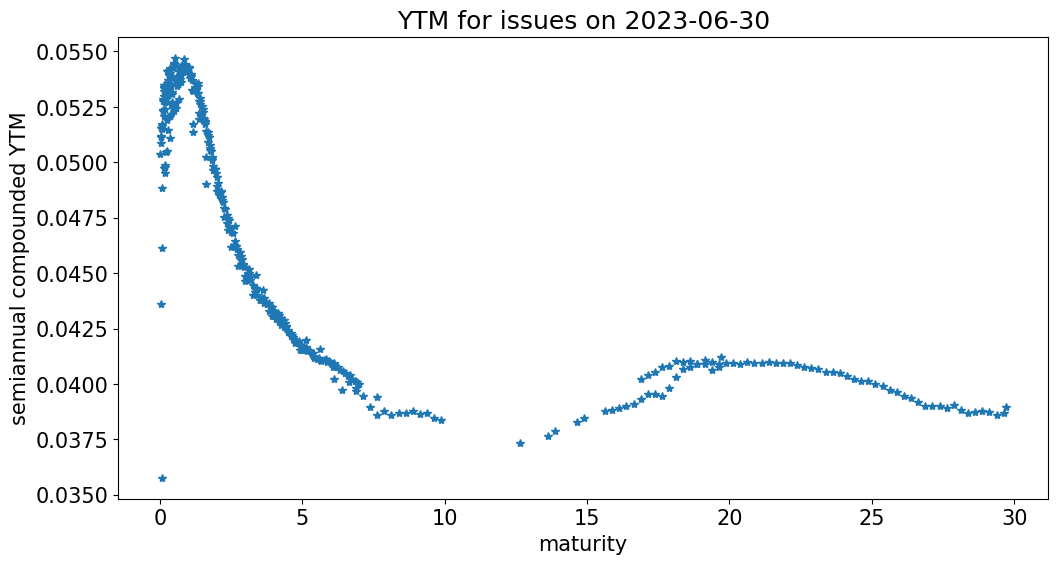

In [17]:
plt.plot(mats_issues.loc[ytm.index],ytm,linestyle='',marker='*')
plt.title(f'YTM for issues on {pd.to_datetime(t_current):%Y-%m-%d}')
plt.ylabel('semiannual compounded YTM')
plt.xlabel('maturity')
plt.show()